OpenAI предоставляет возможность кастомизации (fine-tuning) их базовых моделей с целью улучшения качества выдачи и адаптации к определенной задаче. Вам предлагается реализовать fine-tuning базовой модели *ada* для задачи бинарной классификации текста с использованием приложенных данных.
1. Проведите исследовательский анализ данных.
2. Проведите предобработку данных (очистите, удалите знаки препинания и стоп-слова, токенизируйте, нормализуйте, приведите к нижнему регистру). Выбор инструментов на Ваше усмотрение.
3. Разделите данные на тренировочную, валидационную и тестовую выборки.
4. Подготовьте данные для тренировки в соответствии с требованиями, описанными на сайте https://platform.openai.com.
5. Сделайте fine-tuning базовой модели *ada* на 2 эпохах.
6. Оцените качество Вашей новой модели на тестовой выборке (используйте API OpenAI). Выбор метрик на Ваше усмотрение.

Язык программирования: Python

In [1]:
import sys

import nltk
import openai
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

print('python:'.ljust(16), sys.version.split('\n')[0])
print('openai:'.ljust(16), openai.__version__)

python:          3.11.3 (main, Apr  7 2023, 20:13:31) [Clang 14.0.0 (clang-1400.0.29.202)]
openai:          0.27.7


In [2]:
# Save requirements
!pip freeze > requirements.txt

# Set environment variable
%load_ext dotenv
%dotenv

# Download stopwords
nltk.download('stopwords')

# Set global parameters
RANDOM_STATE = 123456
MAX_SEQUENCE_LEN = 1000

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. EDA

## Load dataset

In [3]:
# Load dataframe
df = pd.read_csv('dataset.csv', index_col=0)

# Rename columns
df.columns = ['prompt', 'completion']

# Show dataframe
df

,prompt,completion
0,Certificate of a Pharmaceutical Product1 This ...,med
1,Risankizumab 2.5 Clinical Overview R&D/22/1116...,med
2,DocuSign Envelope ID: 29755819-FB58-441F-868E-...,med
3,Sandoz Business Use Only Page of Regulatory A...,med
4,InfoCard: PQL-000030 Rev: 001 Effective: 15 Fe...,med
...,...,...
95,vmware- customer connect Welcome to Customer C...,tech
96,CONFIDENTIAL KT&G RESEARCH & DEVELOPMENT 1. De...,tech
97,REGISTRATION RECORD SERIESGOLD SHEETS Internat...,tech
98,"Installation, use and maintenance manual A CLA...",tech


In [4]:
# Show text example
df.loc[2, 'prompt']

'DocuSign Envelope ID: 29755819-FB58-441F-868E-CF4912E1359F Registration number: 1732811000, District Court of Ljubljana, share capital: 48.402.003,00 EUR a Sandoz company To whom it may concern Lek Pharmaceuticals d.d. Verovškova ulica 571526 Ljubljana, SloveniaPhone: +386 1/580 21 11Fax: +386 1/568 35 17www.lek.si Ljubljana, 25 November 2022 We, Lek Pharmaceuticals d.d. (short name Lek d.d.) a manufacturer of pharmaceutical products with business address at Trimlini 2D, 9220 Lendava, Slovenia, company established under the laws of Slovenia, successfully passed EAEU GMP inspection and obtained EAEU GMP certificate. In respect of compliance with Good Manufacturing Practice (GMP) requirements we consent to any further GMP inspection in accordance with Eurasian Economic Union (EAEU) requirements of the manufacturing process of the product(s) Olmesartan medoxomil, Tablet, film-coated, 10 mg, 20 mg and 40 mg performed at manufacturing site: Lek Pharmaceuticals d.d., Poslovna enota PROIZVOD

## Dataframe base info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      100 non-null    object
 1   completion  100 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


___
#### Comments
- **The dataset is in English**
- **There are no missing values (NaN's)**
- **There are only 100 examples**
___

## Unique values

In [6]:
df['completion'].value_counts()

completion
med     50
tech    50
Name: count, dtype: int64

In [7]:
df['prompt'].nunique()

100

___
#### Comments
- **The dataset is balansed**
- **But I still have to use stratified splitting later bacause the dataset is very small**
- **There are no duplicates in "prompt" column**
___

## Text length distribution

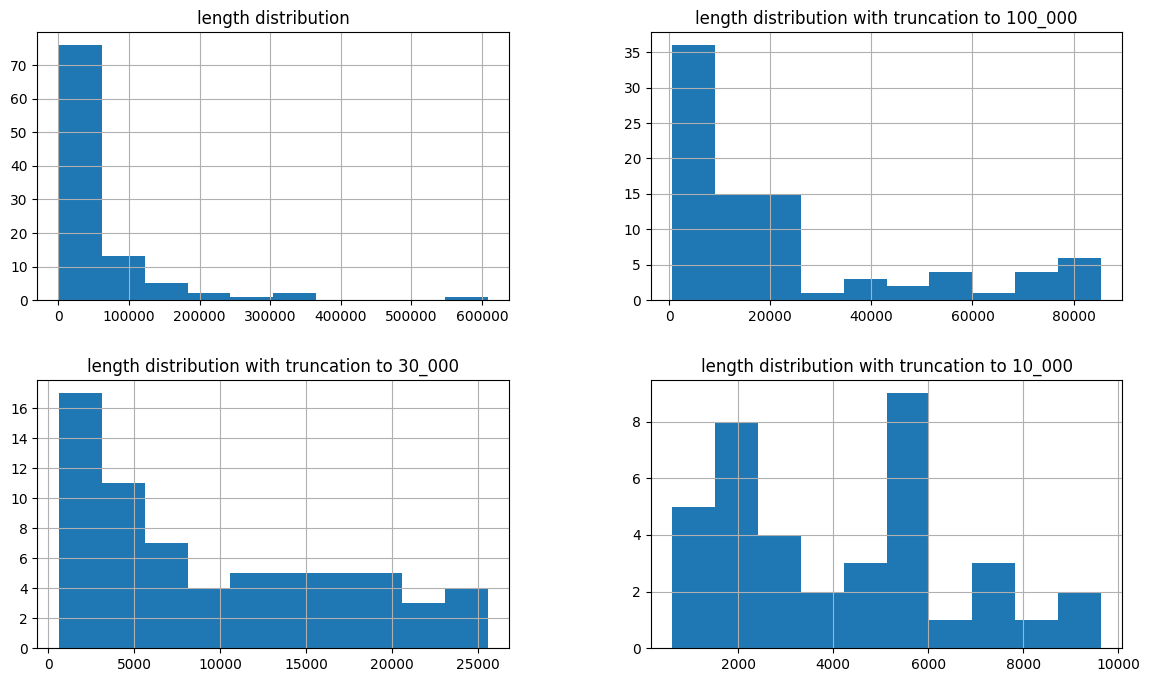

In [8]:
# Compute length of the texts with truncation
text_len = df['prompt'].str.len()
text_len = pd.concat([
    text_len,
    text_len.mask(text_len.gt(100_000)),
    text_len.mask(text_len.gt(30_000)),
    text_len.mask(text_len.gt(10_000)),
], axis=1)
text_len.columns=[
    'length distribution',
    'length distribution with truncation to 100_000',
    'length distribution with truncation to 30_000',
    'length distribution with truncation to 10_000',
]

# Show histograms
text_len.hist(figsize=(14,8));

___
#### Comments
- **Length of the texts varies greatly, from about 1_000 to 600_000 characters**
- **It makes sense to truncate the texts**
___

# 2. Tokenization

## Define Tokenizer

In [9]:
class Tokenizer:
    def __init__(self):
        self.stop_words = nltk.corpus.stopwords.words('english')
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\b[a-z]{3,}\b')
        self.stemmer = nltk.stem.porter.PorterStemmer()

    def __call__(self, text: str, return_str: bool = False) -> list[str] | str:
        # Convert to lower case
        lower_text = text.lower()

        # Tokenize
        tokens = self.tokenizer.tokenize(lower_text)

        tokens_temp = []
        for i, token in enumerate(tokens):
            # Truncate token sequence
            if i > MAX_SEQUENCE_LEN:
                break

            # Remove stop words
            if token in self.stop_words:
                continue

            # Replace links by placeholders
            token = 'http' if token.startswith(('http', 'www')) else token

            # Stemming
            token = self.stemmer.stem(token, to_lowercase=False)

            tokens_temp.append(token)
        tokens = tokens_temp

        # Add a word if len is zero
        if len(tokens) == 0:
            tokens = ['word']

        return ' '.join(tokens) if return_str else tokens

## Try tokenizer

In [10]:
# Initialize tokenizer
tokenizer = Tokenizer()

# Tokenize some crazy text
text_example = "Hello, world! 666Hallowing is _worldwide 666 Don't worry bro, I'm a mad man..."
tokenizer(text_example, return_str=True)

'hello world worri bro mad man'

In [11]:
# Tokenize text example from the dataset
text_example = df.loc[2, 'prompt']
print('Original text:')
print(text_example)
print()
print('Tokenized text:')
print(tokenizer(text_example, return_str=True))

Original text:
DocuSign Envelope ID: 29755819-FB58-441F-868E-CF4912E1359F Registration number: 1732811000, District Court of Ljubljana, share capital: 48.402.003,00 EUR a Sandoz company To whom it may concern Lek Pharmaceuticals d.d. Verovškova ulica 571526 Ljubljana, SloveniaPhone: +386 1/580 21 11Fax: +386 1/568 35 17www.lek.si Ljubljana, 25 November 2022 We, Lek Pharmaceuticals d.d. (short name Lek d.d.) a manufacturer of pharmaceutical products with business address at Trimlini 2D, 9220 Lendava, Slovenia, company established under the laws of Slovenia, successfully passed EAEU GMP inspection and obtained EAEU GMP certificate. In respect of compliance with Good Manufacturing Practice (GMP) requirements we consent to any further GMP inspection in accordance with Eurasian Economic Union (EAEU) requirements of the manufacturing process of the product(s) Olmesartan medoxomil, Tablet, film-coated, 10 mg, 20 mg and 40 mg performed at manufacturing site: Lek Pharmaceuticals d.d., Poslovna 

## Tokenize dataset

In [12]:
%%time
df['prompt'] = df['prompt'].apply(tokenizer.__call__, args=(True,))

CPU times: user 684 ms, sys: 5.21 ms, total: 689 ms
Wall time: 687 ms


# 3. Dataset splitting

___
#### Comments
**As I mentioned earlier, I am using stratification because the dataset is very small.**
___

In [13]:
# Split dataset on training, validation and test parts
df_train, df_test = train_test_split(
    df,
    test_size=0.4,
    shuffle=True,
    stratify=df['completion'],
    random_state=RANDOM_STATE,
)

df_valid, df_test = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test['completion'],
    random_state=RANDOM_STATE,
)

# Show shape of datasets
print('Shape of datasets:')
print('Training  ', df_train.shape)
print('Validation', df_valid.shape)
print('Test      ', df_test.shape)

Shape of datasets:
Training   (60, 2)
Validation (20, 2)
Test       (20, 2)


In [14]:
# Check stratification
print('Class balance of datasets:')
print()
print('Training', df_train['completion'].value_counts())
print()
print('Validation', df_valid['completion'].value_counts())
print()
print('Test', df_test['completion'].value_counts())

Class balance of datasets:

Training completion
med     30
tech    30
Name: count, dtype: int64

Validation completion
med     10
tech    10
Name: count, dtype: int64

Test completion
tech    10
med     10
Name: count, dtype: int64


# 4. Data preparation

In [15]:
# Add a suffix separator to all prompts
prompt_suffix = '\n\n###\n\n'
df_train['prompt'] += prompt_suffix
df_valid['prompt'] += prompt_suffix
df_test['prompt'] += prompt_suffix

# Add a prefix and a suffix to all completions
completion_prefix = ' '
completion_suffix = '\n'
df_train['completion'] = completion_prefix + df_train['completion'] + completion_suffix
df_valid['completion'] = completion_prefix + df_valid['completion'] + completion_suffix
df_test['completion'] = completion_prefix + df_test['completion'] + completion_suffix

# Save datasets to json files
df_train.to_json('train_data.jsonl', orient='records', lines=True)

# 5. Fine-tuning

In [16]:
%%time
!openai api fine_tunes.create -m ada --n_epochs 2 -t "train_data.jsonl"

Upload progress: 100%|███████████████████████| 265k/265k [00:00<00:00, 230Mit/s]
Uploaded file from train_data.jsonl: file-G7jdHRldkZS6OBDzM7h0oJhf
Created fine-tune: ft-YPgwOZQB9ZMevqP4v4EeZgZR
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-21 04:44:21] Created fine-tune: ft-YPgwOZQB9ZMevqP4v4EeZgZR

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-YPgwOZQB9ZMevqP4v4EeZgZR

CPU times: user 1.02 s, sys: 396 ms, total: 1.42 s
Wall time: 1min 4s


# 6. Model evaluation
## Show available models

In [ ]:
!curl https://api.openai.com/v1/models \
  -H "Authorization: Bearer $OPENAI_API_KEY"

## Set API key

In [19]:
with open('.env', 'r') as f:
    api_key = f.read().split('=')[1]
openai.api_key = api_key

## Predict

In [20]:
%%time
def predict(prompt):
    model_name = 'ada:ft-awatera-2023-05-21-00-53-08'
    model_response = openai.Completion.create(model=model_name, prompt=prompt, max_tokens=1, temperature=0)
    return model_response['choices'][0]['text']

y_pred = df_test['prompt'].apply(predict)
y_true = df_test['completion'].str.slice(0, -1)

CPU times: user 136 ms, sys: 20.2 ms, total: 156 ms
Wall time: 8.4 s


## Evaluate

In [21]:
print(f'Model accuracy: {100 * accuracy_score(y_true, y_pred):.2f} %')
print(f'Model F1 score: {100 * f1_score(y_true, y_pred, pos_label=" med"):.2f} %')

Model accuracy: 85.00 %
Model F1 score: 85.71 %
